In [ ]:
# For Google Colab
# ! pip install fastai pretty_midi --upgrade
# ! pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# ! git clone https://github.com/AndreyYashkin/MIDI-gen.git
# % cd MIDI-gen

In [2]:
from fastai.vision.all import *
from src.rnn_models import *
from src.midi import generate_piano_roll, generate_rand_piano_roll, piano_roll_to_pretty_midi

In [3]:
bs = 128
thresh = 0.5
thresh_r = 0.2

frequency = 4
seq_length = 100

notes_num = 88
first_ch = 21
last_ch = 108

# Getting data

In [4]:
# ! rm -rf data

In [4]:
import tarfile
with tarfile.open('data.tar.gz', 'r:gz') as tf:
  tf.extractall()

In [9]:
! ls data | wc -l

89494


In [5]:
def label_func(x): 
  x = str(x)
  one_hot = x[-4-notes_num:-4]
  l = list()
  for i in range(notes_num):
    if one_hot[i] == '1':
      l.append(first_ch + i)
  return l

In [6]:
def strict_acc(inp, targ, thresh=0.5, sigmoid=True):
  "Compute strict accuracy"
  # ignore NaN class
  inp = inp[1:]
  targ = targ[1:]
  if sigmoid: inp = inp.sigmoid()
  inp = (inp > thresh) == targ.bool()
  #print(inp.shape)
  flags, _ = torch.min(inp, dim = 1)
  return flags.float().mean()

def notes_IoU(inp, targ, thresh=0.5, sigmoid=True):
  "Compute Intersection over Union for predicted and true notes"
  if sigmoid: inp = inp.sigmoid()
  inp = inp > thresh
  targ = targ.bool()
  intersection = torch.logical_and(inp, targ).float().sum(dim = 1)
  union = torch.logical_or(inp, targ).float().sum(dim = 1)
  IoU = intersection/union
  # nan means that inp and targ are both have no notes. It is a correct prediction
  # torch.nan_to_num will be introduced only in 1.8.0 :(
  # return torch.nan_to_num(IoU, nan=1).mean() 
  IoU[IoU != IoU] = 1
  return IoU.mean()

# Naive approach

In [7]:
db = DataBlock(blocks = (ImageBlock(cls=PILImageBW), MultiCategoryBlock(add_na = False)), # add a NaN class for images with no notes
                  get_items = get_image_files,
                  splitter = RandomSplitter(seed = 42),
                  get_y = label_func)

dls = db.dataloaders('data', bs = bs)

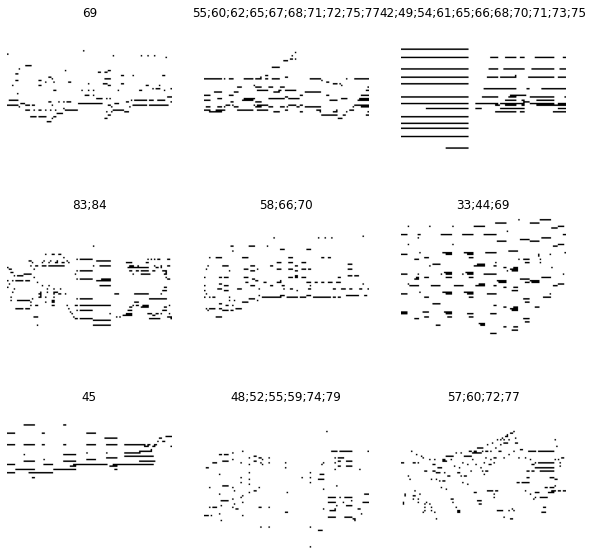

In [ ]:
dls.show_batch(figsize=(10, 10))

In [ ]:
model = SimpleMidiRNN(notes_num, seq_length, 2, False)
learn = Learner(dls, model, loss_func = nn.BCEWithLogitsLoss(), metrics=[notes_IoU, strict_acc, accuracy_multi])

In [ ]:
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,notes_IoU,strict_acc,accuracy_multi,time
0,0.233074,0.141471,0.180200,0.117581,0.963230,01:30
1,0.101496,0.086523,0.348148,0.155930,0.971860,01:28
2,0.091512,0.079225,0.432303,0.209878,0.975182,01:29
3,0.089986,0.078059,0.434226,0.217367,0.975475,01:29
4,0.088431,0.077131,0.451889,0.230657,0.976060,01:28
5,0.088337,0.076663,0.463303,0.241300,0.976428,01:28


In [ ]:
learn.save('gru-2')

Path('models/gru-2.pth')

In [ ]:
model = SimpleMidiRNN(notes_num, seq_length, 2, True)
learn = Learner(dls, model, loss_func = nn.BCEWithLogitsLoss(), metrics=[notes_IoU, strict_acc, accuracy_multi])

In [ ]:
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,notes_IoU,strict_acc,accuracy_multi,time
0,0.161849,0.100797,0.291230,0.130195,0.969434,01:33
1,0.089382,0.077186,0.462495,0.240343,0.976249,01:34
2,0.083620,0.075109,0.494057,0.271427,0.977402,01:34
3,0.081008,0.074099,0.506629,0.285843,0.977903,01:34
4,0.081112,0.073677,0.510124,0.293558,0.978127,01:36
5,0.080171,0.073565,0.515230,0.297950,0.978210,01:36


In [ ]:
learn.save('gru-2-bi')

Path('models/gru-2-bi.pth')

# IoU loss

Let's try to change loss function

In [8]:
def jaccard_index(output, target):
  output = output.sigmoid()
  intersection_s = (output * target).sum(dim = 1)
  output_s = output.sum(dim = 1)
  target_s = target.sum(dim = 1)
  return (intersection_s/(output_s + target_s - intersection_s)).mean()

def jaccard_distance(output, target):
  return 1 - jaccard_index(output, target)

In [ ]:
db_na = DataBlock(blocks = (ImageBlock(cls=PILImageBW), MultiCategoryBlock(add_na = True)), # add a NaN class for images with no notes
                  get_items = get_image_files,
                  splitter = RandomSplitter(seed = 42),
                  get_y = label_func)

dls_na = db_na.dataloaders('data', bs = bs)

In [ ]:
dls_na.vocab

['#na#', 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108]

In [ ]:
model = SimpleMidiRNN(notes_num, seq_length, 2, False, nan_class = True)
learn = Learner(dls_na, model, loss_func = jaccard_distance, metrics=[notes_IoU, strict_acc])

In [ ]:
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,notes_IoU,strict_acc,time
0,0.880292,0.839706,0.265502,0.021962,01:31
1,0.640837,0.558822,0.519649,0.263881,01:32
2,0.594422,0.541773,0.524137,0.270188,01:33
3,0.582349,0.539601,0.524159,0.270357,01:34
4,0.582438,0.539197,0.524234,0.270413,01:33
5,0.579203,0.539105,0.524242,0.270413,01:35


In [ ]:
learn.save('gru-2-jaccard')

Path('models/gru-2-jaccard.pth')

No dramatic difference

# Model with a couple conv layers

In [8]:
model = ConvMidiRNN(seq_length, notes_num)
learn = Learner(dls, model, loss_func = nn.BCEWithLogitsLoss(), metrics=[notes_IoU, strict_acc, accuracy_multi])

In [ ]:
learn.fit_one_cycle(12)

epoch,train_loss,valid_loss,notes_IoU,strict_acc,accuracy_multi,time
0,0.492885,0.386254,0.447938,0.154185,0.963498,01:38
1,0.101752,0.083762,0.410185,0.180652,0.973242,01:37
2,0.089103,0.077503,0.462078,0.224575,0.975205,01:37
3,0.084188,0.075235,0.481822,0.244453,0.976369,01:40
4,0.080846,0.073257,0.500892,0.273961,0.977795,01:38
5,0.078197,0.072025,0.503372,0.287758,0.978346,01:38
6,0.078096,0.071064,0.511895,0.298513,0.978630,01:37
7,0.075406,0.070613,0.522753,0.311578,0.978981,01:36
8,0.074680,0.070099,0.516112,0.311240,0.978983,01:37
9,0.073395,0.069959,0.513847,0.311353,0.978988,01:37


In [ ]:
learn.save('ConvMidiRNN')

Path('models/ConvMidiRNN.pth')

# Piano roll generation examples

In [9]:
learn.load('ConvMidiRNN')

In [10]:
model = model.eval()

Deterministic

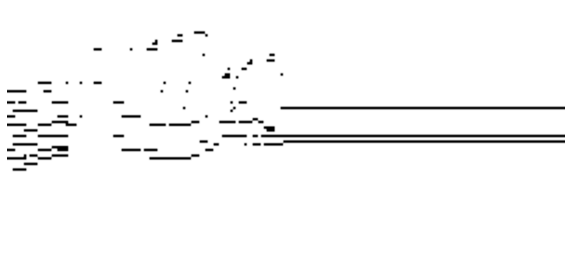

In [13]:
roll = generate_piano_roll(model.cpu(), seq_length, dls.valid_ds[7][0], 100, thresh)
roll.show(figsize=(10, 10))

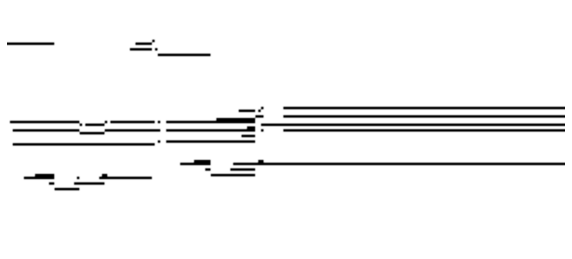

In [ ]:
roll = generate_piano_roll(model.cpu(), seq_length, dls.valid_ds[12][0], 100, thresh)
roll.show(figsize=(10, 10))

Randomized

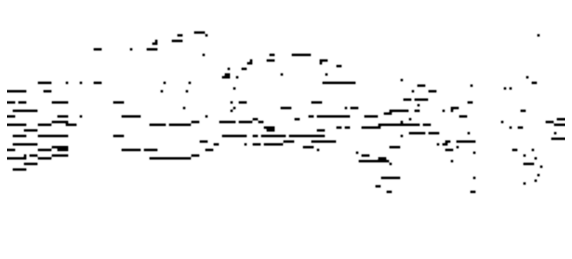

In [ ]:
roll = generate_rand_piano_roll(model.cpu(), seq_length, dls.valid_ds[7][0], 100)
roll.show(figsize=(10, 10))

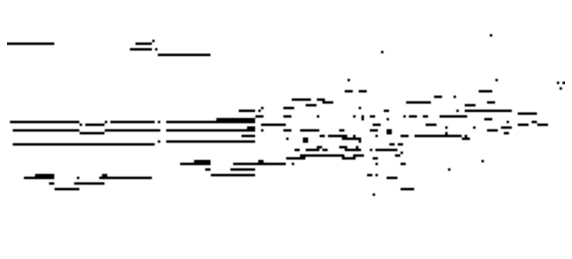

In [ ]:
roll = generate_rand_piano_roll(model.cpu(), seq_length, dls.valid_ds[12][0], 100)
roll.show(figsize=(10, 10))

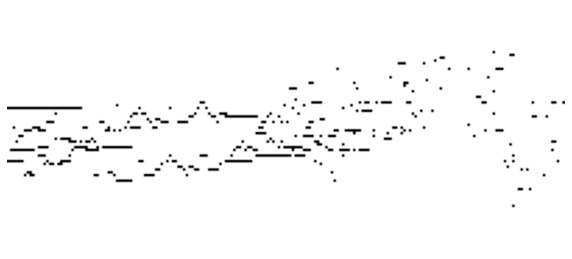

In [ ]:
roll = generate_rand_piano_roll(model.cpu(), seq_length, dls.valid_ds[17][0], 100)
roll.show(figsize=(10, 10))

In [13]:
! python3 gen.py data/2014_MIDI-UNPROCESSED_16-18_R1_2014_MID--AUDIO_16_R1_2014_wav--2.midi_[1560,1660]___0000000000000000000000000000001000010100010010000000000000000000000000000000000000000000.png example_1.mid 100

In [14]:
! python3 gen.py data/2017_MIDI-Unprocessed_047_PIANO047_MID--AUDIO-split_07-06-17_Piano-e_2-04_wav--1.midi_[520,620]___0000000000000000000000000000000000000010010000100000000000000000000000000000000000000000.png example_2.mid 100

In [15]:
! python3 gen.py data/2015_MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-from_mp3_12_R1_2015_wav--5.midi_[920,1020]___0000000000000000000000000000000000000000000000000000000000000000000000010000000000000000.png example_3.mid 100

In [16]:
! python3 gen.py data/2006_MIDI-Unprocessed_03_R1_2006_01-05_ORIG_MID--AUDIO_03_R1_2006_04_Track04_wav.midi_[380,480]___0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000.png example_4.mid 100

In [18]:
! python3 gen.py data/2006_MIDI-Unprocessed_01_R1_2006_01-09_ORIG_MID--AUDIO_01_R1_2006_01_Track01_wav.midi_[6740,6840]___0000000000000000000000000000000000000110010000000110010000000000000000000000000000000000.png example_5.mid 100